In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import warnings
warnings.simplefilter('ignore')

In [7]:
# Additional data cleaning
X = pd.read_csv("cleaned_with_salaries.csv")

X = X[['meanschooladministratorsalaryind', 'administratortoteachermeansalary', 
       'students_11_12', 'gradrate', 'charter', 'attendance22', 'male_2022_p', 
       'attendance_2022_minority_p', 'economicallydisadvantaged_2022_p', 'log_students',]]
# I took out district and attendance21 for collinearity purposes
# Included male, minority attendance, economically disadvantaged

# Some attendance values are null. These will be dropped
X = X.dropna()
y_rate = X['gradrate'].copy()

# Define average graduation rates
NATIONAL_GRAD_RATE = .87
UTAH_GRAD_RATE = .882
y = y_rate > UTAH_GRAD_RATE

# Remove the graduation rate column from X
del X['gradrate']

# Define the sample weights based on the number of 11th and 12th graders students_11_12
weights = X['students_11_12'] / X['students_11_12'].sum()
# Remove the population column
del X['students_11_12']

### Graduation Rates

Our final analysis studies a school's graduation rate as the target variable. Graduation rates are expressed as a percentage, so each $y_i \in [0,1]$. As such, a logistic regression would be more appropriate to model the data. In order to do this, we split our target data around the average high school graduation rate in Utah [https://www.schools.utah.gov/file/f40bd425-7583-4b56-8835-473a97b75326#:~:text=Graduation%20Rate%20Highlights,-%E2%80%A2&text=Utah's%20state%20graduation%20rate%20for%20the%202022%20cohort%20is%2088.2%25.&text=Five%20of%20the%20nine%20reported,their%20graduation%20rate%20from%202021.&text=A%20total%20of%2045432%20students%20graduated%20from%20Utah's%20high%20schools.&text=Utah's%20graduation%20rate%20has%20increased,2021%20to%2088.2%25%20in%202022.], which is 0.882. Therefore, our target variable is 

$$ \tilde{y_i} = 
\begin{cases} 
    1 & y_i \geq 0.882 \\
    0 & y_i < 0.882 
\end{cases}
$$

Any $\tilde{y_i} = 1$ corresponds to a high school with an above-average graduation rate, while a $\tilde{y_i} = 0$ corresponds to a below-average graduation rate.

We use the following features for our model: mean school administrator salary indicator, administrator to teacher mean salary, an indicator for whether the school is a charter school, the attendance rates for all students, the male attendance rate, the attendance rate of minority students, the attendance rate of economically disadvantaged students, and the logarithm of the total number of students in the school. As before, our model was weighted by student population. Additionally, a regularization constant of 0.5 was included. Our results are as follows:

In [8]:
# Run the optimal regression and display results
# The alpha term is the regularization term
#warnings.simplefilter('ignore')
log_reg = sm.Logit(y, sm.add_constant(X)).fit_regularized(disp=False, weights=weights)
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               gradrate   No. Observations:                  129
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                            8
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.2201
Time:                        17:35:59   Log-Likelihood:                -68.855
converged:                       True   LL-Null:                       -88.293
Covariance Type:            nonrobust   LLR p-value:                 5.186e-06
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              -20.6020      7.238     -2.846      0.004     -34.788      -6.416
meanschooladministratorsalaryind -7.007e-06   1.31e-05     -0.537      0.591   -3.26e-05    1.86e-05
administratortoteachermeansalary    -0.5816      0.558     -1.042      0.297      -1.675       0.512
charter                             -0.9840      0.637     -1.545      0.122      -2.232       0.264
attendance22                        25.8759      7.589      3.410      0.001      11.002      40.750
male_2022_p                         -2.4351      3.727     -0.653      0.514      -9.741       4.871
attendance_2022_minority_p          -1.2526      1.310     -0.956      0.339      -3.820       1.315
economicallydisadvantaged_2022_p    -1.0507      1.260     -0.834      0.404      -3.521       1.419
log_students                         0.1684      0.220      0.765      0.444      -0.263       0.600
====================================================================================================
"""

The above table summarizes our findings. The only variables considered to be statistically significant are the intercept and the attendance variable. All other varaibles have a p-value of at least 0.1. Male attendance, minority attendance, and economically disadvantaged attendance are negatively correlated with graduation rates, but these coefficients are statistically insignificant. More research would be needed to determine whether these variables are truly negatively correlated.

It seems very intuitive that attendance is strongly correlated with graduation rates. After all, students who do not graduate high school generally don't attend frequently. Additionally, in Utah (and most other states), high school graduation requirements are such that simply attending goes a long way in helping a student graduate.

To further analyze the correlation between attendance and graduation rates, we ran a simple logistic regression with attendance as the only feature. A summary and graph is included below: 

In [9]:
attendance = X[['attendance22']]
attendance = sm.add_constant(attendance)
attend_model = sm.Logit(y, attendance).fit_regularized(disp=False, weights=weights)
attend_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               gradrate   No. Observations:                  129
Model:                          Logit   Df Residuals:                      127
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.1414
Time:                        17:36:01   Log-Likelihood:                -75.806
converged:                       True   LL-Null:                       -88.293
Covariance Type:            nonrobust   LLR p-value:                 5.814e-07
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -22.7610      6.153     -3.699      0.000     -34.821     -10.701
attendance22    25.0874      6.678      3.757      0.000      12.000      38.175
================================================================================
"""

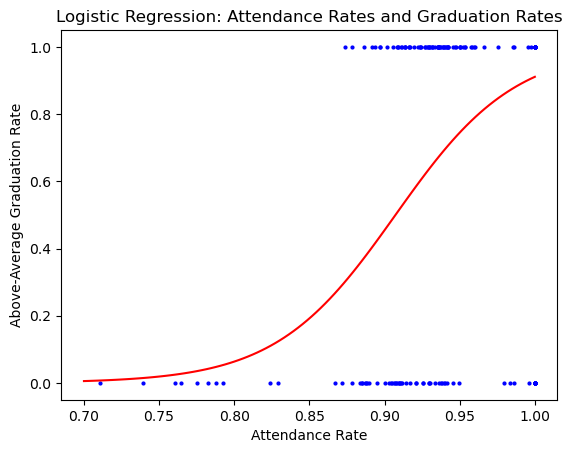

In [10]:
plt.plot(attendance, y, 'bo', markersize=2)
domain = np.linspace(0.7,1,100)
beta = attend_model.params.values
model = np.vectorize(lambda x: (1 + np.exp(-1*(beta[0] + x*beta[1])))**-1)
plt.plot(domain, model(domain), 'r-')
plt.title("Logistic Regression: Attendance Rates and Graduation Rates")
plt.xlabel("Attendance Rate")
plt.ylabel("Above-Average Graduation Rate")
plt.show()

Again, there is a clear positive correlation between the attendance rate and whether a high school has an above-average graduation rate.

We concluded that graduation rate is not a strong indicator of student success due to the lack of standardization. Different high schools and districts have different graduation requirements, so one high school's graduation rate does not always relate well to that of another high school.